# Modeling Phase – Baseline & Classical Models

In this notebook, we:

- Implement naive and moving average baseline forecasts to establish reference performance.
- Build and evaluate ARIMA/SARIMA models on the target energy consumption time series.
- Perform feature engineering to improve the model performance.
- Use grid search to find the best model parameters for the ARIMA and SARIMAX models.
- Compare results using standard metrics (MAE, RMSE, MAPE, R²).
- Use the model coefficients to identify the most relevant features for the forecast.

# Libraries

In [1]:
# System & Data Handling
# import os
# import shutil
import pickle

# Data Loading
# import kagglehub
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
# import calendar

# Time Series Analysis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)

# Loading cleaned data
Loading the cleaned data from EDA phase

In [2]:
with open('../data/data_cleaned.pkl', 'rb') as f:
    data_cleaned = pickle.load(f)

df_data = data_cleaned['df_data']
df_data = df_data.drop(columns=['DayOfWeek','RollingMean']).rename(columns = {'DayOfWeek_ext':'DayOfWeek'})
df_data.head()


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek
Timestamp,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,Off,Off,14.391800,No,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,On,Off,25.875969,Yes,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,On,Off,17.471965,Yes,75.251764,2022-01-04,2,Tuesday
2022-01-04 03:00:00,22.140257,49.424878,1037.206885,7,Off,On,3.329908,Yes,75.014471,2022-01-04,3,Tuesday
2022-01-04 04:00:00,24.175776,41.800150,1198.625224,6,Off,Off,18.470624,No,69.365745,2022-01-04,4,Tuesday


In [3]:
df_data_24h_complete = data_cleaned['df_data_24h_complete']
df_data_24h_complete.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,Date,Time,DayOfWeek_ext
Timestamp,,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,Off,Off,14.391800,Friday,No,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,On,Off,25.875969,Wednesday,Yes,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,On,Off,17.471965,Sunday,Yes,75.251764,2022-01-04,2,Tuesday
2022-01-04 03:00:00,22.140257,49.424878,1037.206885,7,Off,On,3.329908,Tuesday,Yes,75.014471,2022-01-04,3,Tuesday
2022-01-04 04:00:00,24.175776,41.800150,1198.625224,6,Off,Off,18.470624,Sunday,No,69.365745,2022-01-04,4,Tuesday


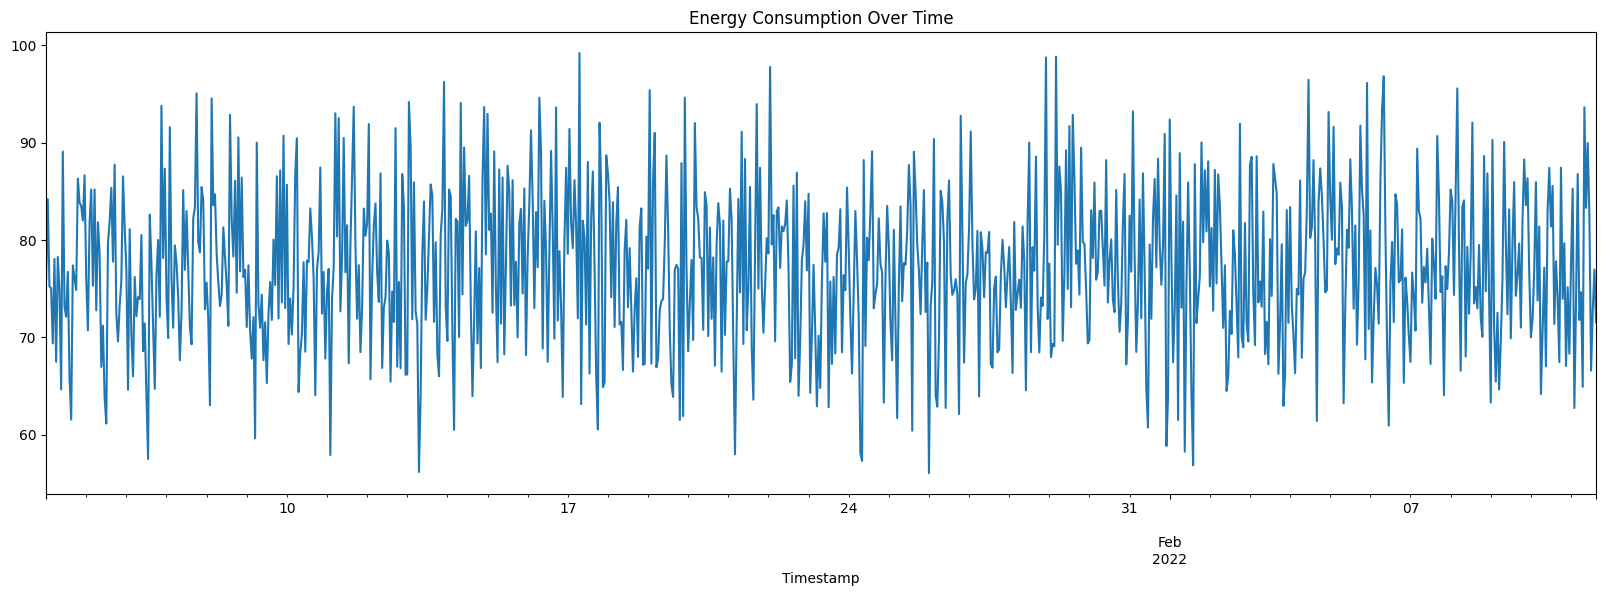

In [4]:
df_data['EnergyConsumption'].plot(title="Energy Consumption Over Time", figsize=FIGSIZE_LONG)
plt.show()

# Utility functions:
- Evaluation of prediction using the metrics, MAE, RMSE, MAPE, and R2
- Visualizaiton of the training, test, and prediction samples

In [5]:

def evaluate_model(df_predictions, verbose=True):
    y_pred = df_predictions['prediction'].values
    y_true = df_predictions['truth'].values

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2   = r2_score(y_true, y_pred)

    if verbose:
        print("Rolling-Window Forecast Evaluation:")
        print(f"MAE:  {mae:.3f}")
        print(f"RMSE: {rmse:.3f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"R2:   {r2:.4f}")

    results = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

    return results

def visualize_prediction(df_predictions, df_data, title, last_n_samples=48):
    # Visualize the prediction
    df_viz = df_data.iloc[-last_n_samples:].copy()
    plt.figure(figsize=(12, 5))
    plt.plot(df_viz.index, df_viz['EnergyConsumption'],  label="Training Data",    marker='o')
    plt.plot(df_predictions.index, df_predictions['truth'],  label="Test Data",    marker='o')
    plt.plot(df_predictions.index, df_predictions['prediction'],  label="Forecast",  marker='x', linestyle='--')
    plt.title(title)
    plt.xlabel("Timestamp")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Test/ Train data split

In [6]:
# import numpy as np

forecast_horizon = 24
target_col = 'EnergyConsumption'
train_hr = df_data.iloc[:-forecast_horizon][target_col].asfreq('h')
test_hr = df_data.iloc[-forecast_horizon:][target_col].asfreq('h')

forecast_horizon = 7
df_daily = df_data_24h_complete['EnergyConsumption'].resample('D').sum()
df_daily = df_daily.to_frame()
train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')


# Baseline model - moving average
We use the moving average model and a rolling windows on the past samples to predict the next sample of the data

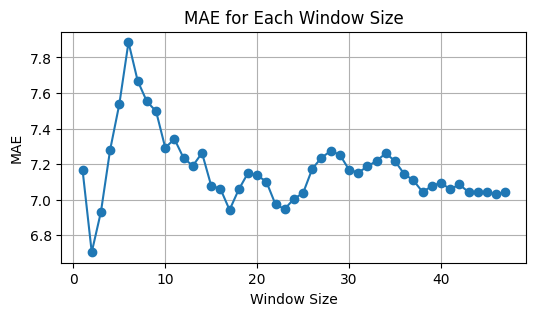

The best window size is 2 with a MAE of 6.70%
Rolling-Window Forecast Evaluation:
MAE:  6.704
RMSE: 68.051
MAPE: 8.75%
R2:   -0.0125


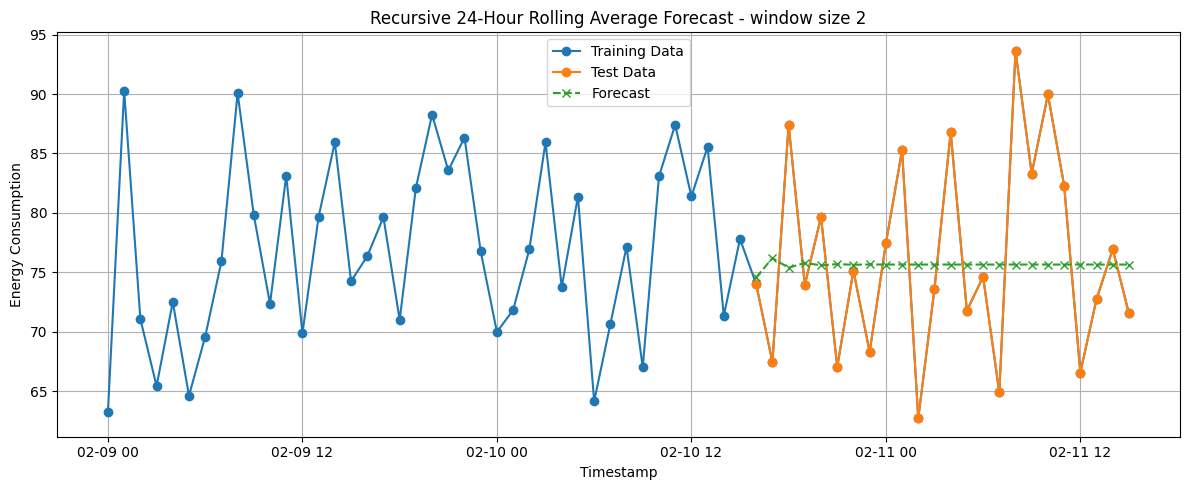

In [7]:
# Rolling window of data for each 24 samples

def rolling_window_forecast(train, test, window_size, verbose=False):

    df_predictions = pd.DataFrame(index=test.index, columns=['prediction', 'truth'])
    df_predictions['truth'] = test.values

    history = train.iloc[-window_size:].tolist()

    for ts in df_predictions.index:
        next_pred = np.mean(history[-window_size:])
        df_predictions.loc[ts, 'prediction'] = next_pred
        history.append(next_pred)
    
    results = evaluate_model(df_predictions, verbose=verbose)
    
    return df_predictions, results

import matplotlib.pyplot as plt

def grid_search_rolling_window_forecast(train, test, param_range=range(1, 24)):
    # collect (window_size, mape) for each trial
    results = []

    for window_size in param_range:
        if window_size > len(train):
            print(f"Window size {window_size} is greater than the training data length {len(train)}")
            continue

        df_pred, metrics = rolling_window_forecast(train, test, window_size)
        results.append((window_size, metrics['mae']))

    # unpack into two lists if you still want to plot
    window_sizes, mapes = zip(*results)

    # plot the MAPE for each window size
    plt.figure(figsize=(6, 3))
    plt.plot(window_sizes, mapes, marker='o')
    plt.xlabel("Window Size")
    plt.ylabel("MAE")
    plt.title("MAE for Each Window Size")
    plt.grid(True)
    plt.show()

    # find the (window_size, mape) tuple with smallest mape
    best_window, best_mape = min(results, key=lambda x: x[1])
    print(f"The best window size is {best_window} with a MAE of {best_mape:.2f}%")

    return best_window, best_mape, results


window_size_best, min_mape, all_mape = grid_search_rolling_window_forecast(train_hr, test_hr, param_range=range(1, 48))

# prediction with the best forecast horizon
df_predictions_baseline, results_baseline = rolling_window_forecast(train_hr, test_hr, window_size_best, verbose=True)

# Visualize the prediction
title = f"Recursive 24-Hour Rolling Average Forecast - window size {window_size_best}"
visualize_prediction(df_predictions_baseline, df_data, title, last_n_samples=64)


## Baseline - daily prediciton

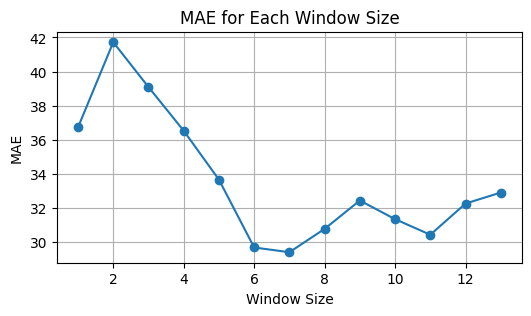

The best window size is 7 with a MAE of 29.42%
Rolling-Window Forecast Evaluation:
MAE:  29.422
RMSE: 1391.545
MAPE: 1.56%
R2:   -0.1345


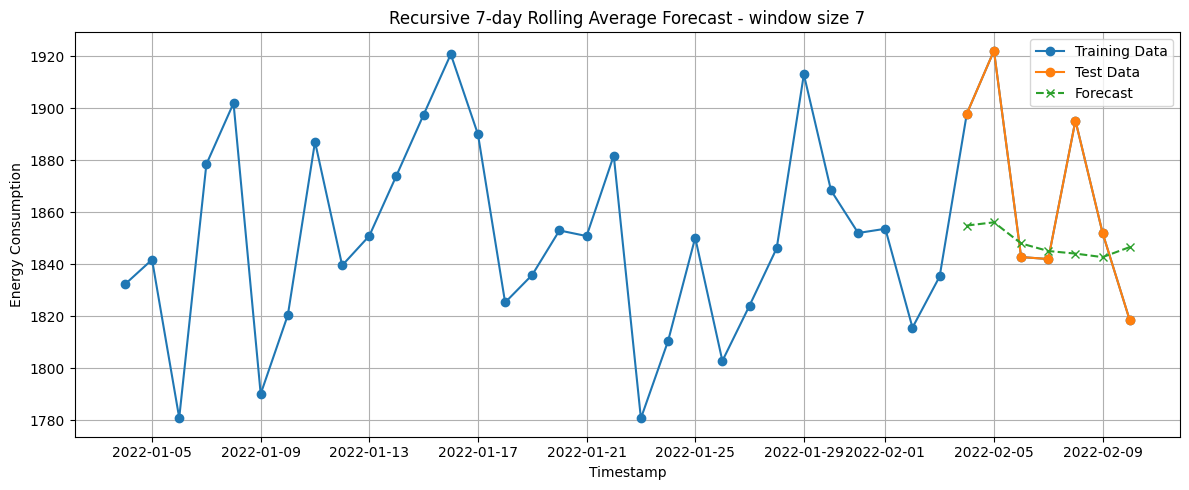

,Baseline_24h,Baseline_Daily
mae,6.704103,29.422096
rmse,68.050988,1391.544903
mape,8.750275,1.557443
r2,-0.012465,-0.134533


In [8]:

window_size_best, min_mape, all_mape = grid_search_rolling_window_forecast(train_day, test_day, range(1, 14))

df_predictions, results_baseline_daily = rolling_window_forecast(train_day, test_day, window_size_best, verbose=True)
# Visualize the prediction
title = f"Recursive 7-day Rolling Average Forecast - window size {window_size_best}"
visualize_prediction(df_predictions, df_daily, title, last_n_samples=64)

df_model_results = pd.DataFrame({'Baseline_24h':results_baseline, 'Baseline_Daily':results_baseline_daily})
df_model_results


# ARIMA model
The arima model has the parameters (p, d, q), refereing to the AR (AutoRegressive), differencing, and MA (Moving Average) parts of the model.

In [88]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import matplotlib.pyplot as plt
from itertools import product

def arima_model(train, test, order):
    ''' This function fits an ARIMA model to the training data and returns a dataframe of the predictions and the true values.
    Args:
        train: pd.Series, the training data
        test: pd.Series, the test data
        order: tuple, the order of the ARIMA model (p,d,q)
    Returns:
        df_predictions: pd.DataFrame, the predictions and the true values
    '''
    # Fit ARIMA with selected order
    model = ARIMA(train, order=order)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", 
            message=".*divide by zero encountered.*|.*overflow encountered.*|.*invalid value encountered.*|.*Using zeros.*|.*Maximum Likelihood optimization*.")
        model_fit = model.fit()
    
    
    forecast_horizon = len(test)
    # Forecast
    forecast = model_fit.forecast(steps=forecast_horizon)

    # Wrap into dataframe for evaluation
    df_predictions = pd.DataFrame(index=test.index)
    df_predictions['prediction'] = forecast.values 
    df_predictions['truth'] = test.values

    return df_predictions

def extract_best_params(all_results, labels, errors, figsize=FIGSIZE_LONG, metric = 'mape'):
        plt.figure(figsize=figsize)
        plt.plot(labels, errors, marker='o')
        plt.xticks(rotation=90, ha='right')
        plt.xlabel("ARIMA(p,d,q) order")
        plt.ylabel(f"{metric}")
        plt.title(f"ARIMA Grid Search — {metric} by Order")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

        # pick the best
        *best_order, best_mape = min(all_results, key=lambda x: x[-1])
        return best_order, best_mape

def grid_search_arima(train, test,
                      p_range=range(0, 10),
                      d_range=range(0, 2),
                      q_range=range(0, 10), figsize=FIGSIZE_LONG, metric = 'mape', verbose=False):
    """
    Grid‐search ARIMA(p,d,q) by evaluating MAPE on the hold‐out `test` set.
    Returns: best_order, best_mape, all_results
      - best_order: tuple (p,d,q)
      - best_mape:   float
      - all_results: list of (order, mape)
    """
    all_results = []
    for p, d, q in product(p_range, d_range, q_range):
        order = (p, d, q)
        if verbose:
            print(f"Fitting ARIMA({order})")
        # fit & forecast
        df_pred = arima_model(train, test, order)        
        m = evaluate_model(df_pred, verbose=False)
        all_results.append((order, m[metric]))

    # unpack for plotting
    orders, errors = zip(*all_results)

    # convert orders to a string for x‐axis labels
    labels = [f"{o[0]},{o[1]},{o[2]}" for o in orders]    
    
    best_order, best_mape = extract_best_params(all_results, labels, errors, figsize, metric)

    print(f"Best ARIMA order: {best_order} → {metric} = {best_mape:.2f}")
    return best_order, best_mape, all_results


## 24 hour forcast
We fit the ARIMA model to the hourly consumption data to forcast its future values

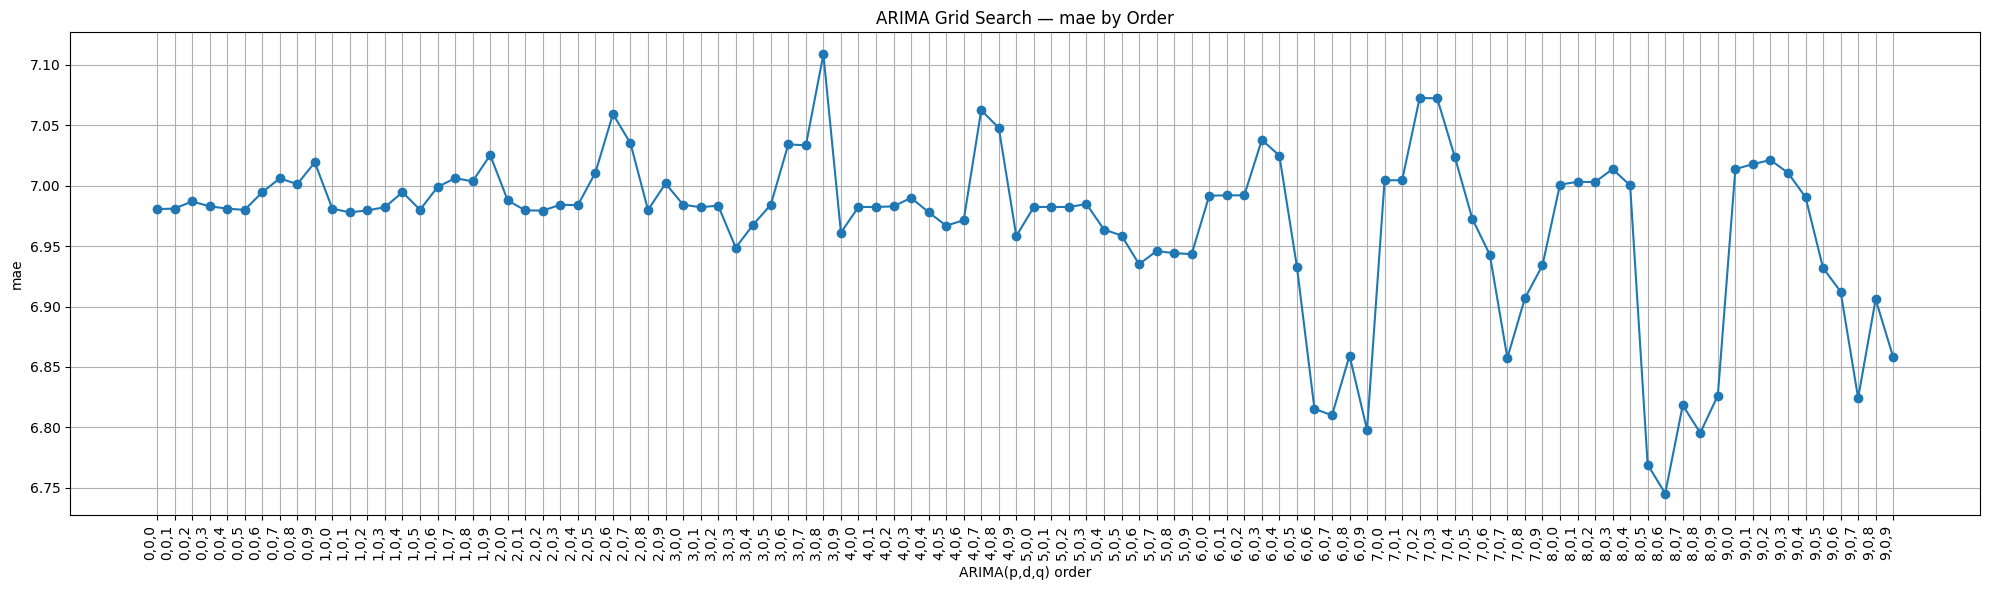

Best ARIMA order: [(8, 0, 6)] → mae = 6.75
Rolling-Window Forecast Evaluation:
MAE:  6.745
RMSE: 66.352
MAPE: 9.01%
R2:   0.0128


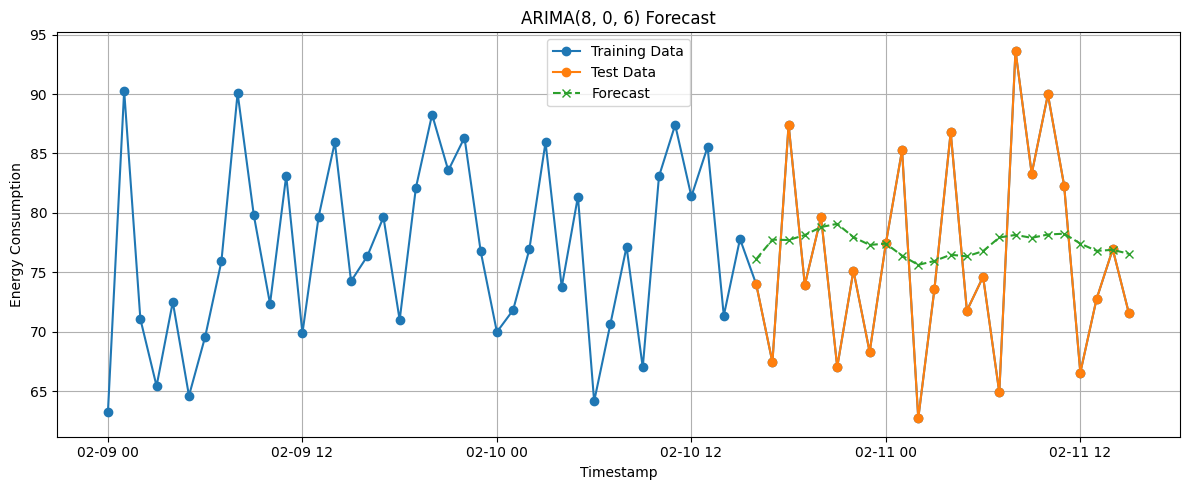

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily,SARIMAX_24h
mae,6.704103,29.422096,6.745177,20.979117,4.365473
rmse,68.050988,1391.544903,66.351638,719.619933,32.060373
mape,8.750275,1.557443,9.008152,1.122592,5.752766
r2,-0.012465,-0.134533,0.012818,0.413290,0.523004


In [125]:
# --- USAGE ---
best_order, best_mape, results = grid_search_arima(
    train_hr,
    test_hr,
    p_range=range(0,10),
    d_range=[0],
    q_range=range(0,10),
    metric='mae'
)
best_order = best_order[0]
df_predictions = arima_model(train_hr, test_hr, best_order)
result_arima =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title=f"ARIMA{best_order} Forecast", last_n_samples=64)
df_model_results['ARIMA_24h'] = result_arima
df_model_results


## 7-day forcast
Here we fit the ARIMA model to the daily consumption data

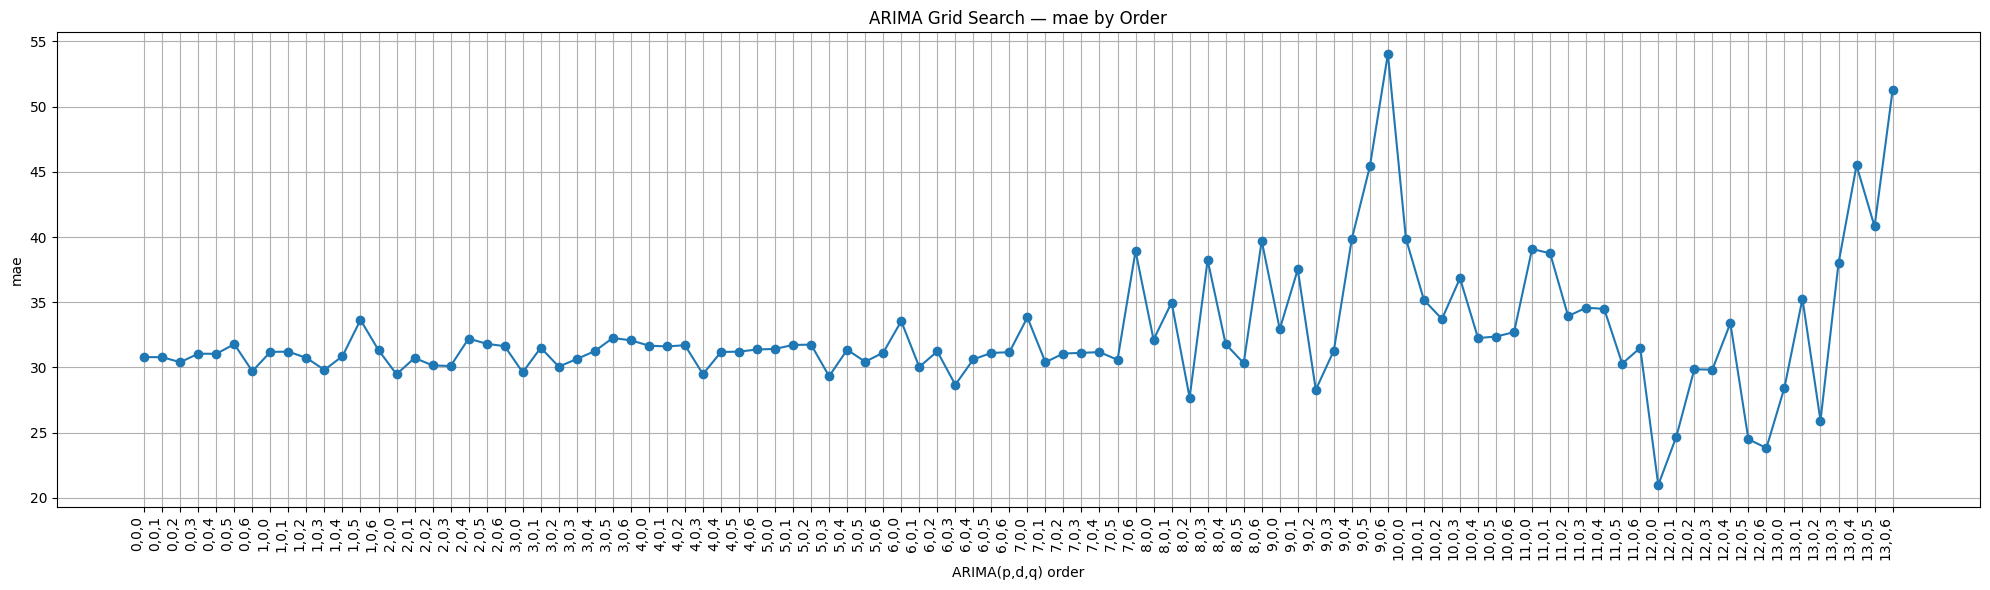

Best ARIMA order: (12, 0, 0) → mae = 20.98
Rolling-Window Forecast Evaluation:
MAE:  20.979
RMSE: 719.620
MAPE: 1.12%
R2:   0.4133


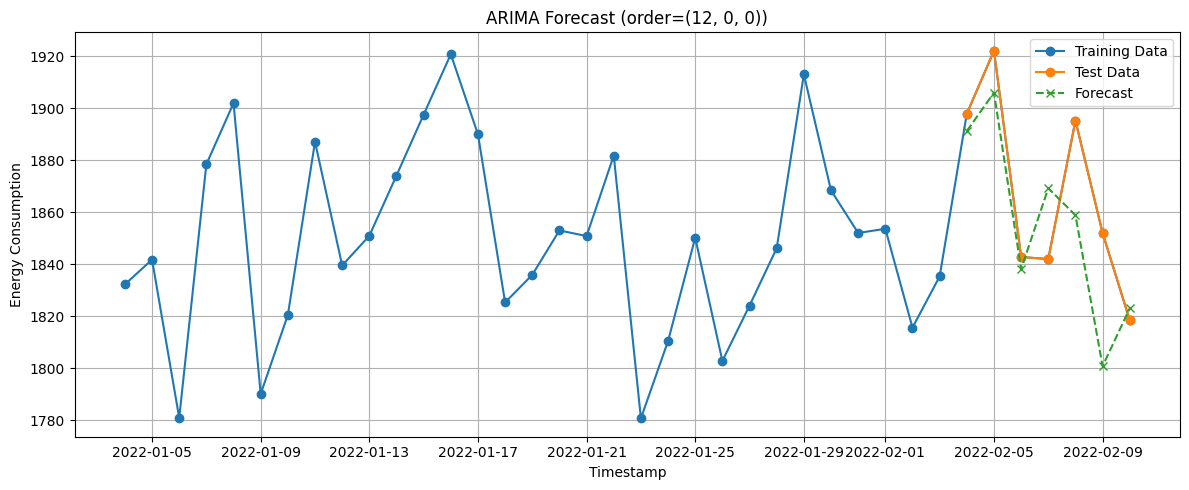

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily
mae,6.704103,29.422096,6.745177,20.979117
rmse,68.050988,1391.544903,66.351638,719.619933
mape,8.750275,1.557443,9.008152,1.122592
r2,-0.012465,-0.134533,0.012818,0.413290


In [11]:
# import test
train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')

best_order_daily, best_mape_daily, results_daily = grid_search_arima(
    train_day,
    test_day,
    p_range=range(0,14),
    d_range=[0],
    q_range=range(0,7),
    metric= 'mae'
)

df_predictions_daily = arima_model(train_day, test_day, best_order_daily)
# Evaluate and visualize
result_arima_daily = evaluate_model(df_predictions_daily, verbose=True)
title = f"ARIMA Forecast (order={best_order_daily})"
visualize_prediction(df_predictions_daily, df_daily, title, last_n_samples=64)
df_model_results['ARIMA_Daily'] = result_arima_daily
df_model_results


**Observations:**
- We observe that there is not much difference in performance of baseline and the ARIMA model for hourly prediction.
- However ARIMA had a fairly good prediction for daily consumption, especially compared to the baseline


# Feature Engineering for multivariable model
We want to use other features included in the dataset to investigate their impact on forcasting the target variable.
To that aim, we perform features engineering on both categorical and numeric variables.

## Categorical Features' encoding
- Holiday
- DayOfWeek
- HVACUsage
- LightingUsage



In [12]:
cat_cols = df_data.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Date', 'Time']]
# num_cols = df_data.select_dtypes(include=['int64', 'float64']).columns

print('Categorical Features: ', cat_cols)
# print('\nNumerical Features: ', num_cols)
for col in cat_cols:
    print(f'Unique values in {col}: {df_data[col].unique()}')
# df_data[cat_cols].head()

Categorical Features:  ['HVACUsage', 'LightingUsage', 'Holiday', 'DayOfWeek']
Unique values in HVACUsage: ['Off' 'On']
Unique values in LightingUsage: ['Off' 'On']
Unique values in Holiday: ['No' 'Yes']
Unique values in DayOfWeek: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']


In [13]:
df_features = df_data.copy()
df_features['HVACUsage'] = df_features['HVACUsage'].map({'On': 1, 'Off': 0})
df_features['LightingUsage'] = df_features['LightingUsage'].map({'On':1, 'Off': 0})
df_features['Holiday'] = df_features['Holiday'].map({'Yes':1, 'No': 0})
df_features.head(3)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek
Timestamp,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,0,0,14.391800,0,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,1,0,25.875969,1,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,1,0,17.471965,1,75.251764,2022-01-04,2,Tuesday


## Time-based features
- Day of week
- Month
- Hour of the day is already extracted in EDA

In [14]:
df_features['DayOfWeek'] = df_features.index.weekday
df_features['Month'] = df_features.index.month
df_features.head(3)

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek,Month
Timestamp,,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,0,0,14.391800,0,75.913906,2022-01-04,0,1,1
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,1,0,25.875969,1,84.191467,2022-01-04,1,1,1
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,1,0,17.471965,1,75.251764,2022-01-04,2,1,1


## Correlation between Energy consumptions and new features
- Besides tempreture, the correlation matrix shows also slight correlation between {Occupancy, HVACUsage} and the Energy consumption

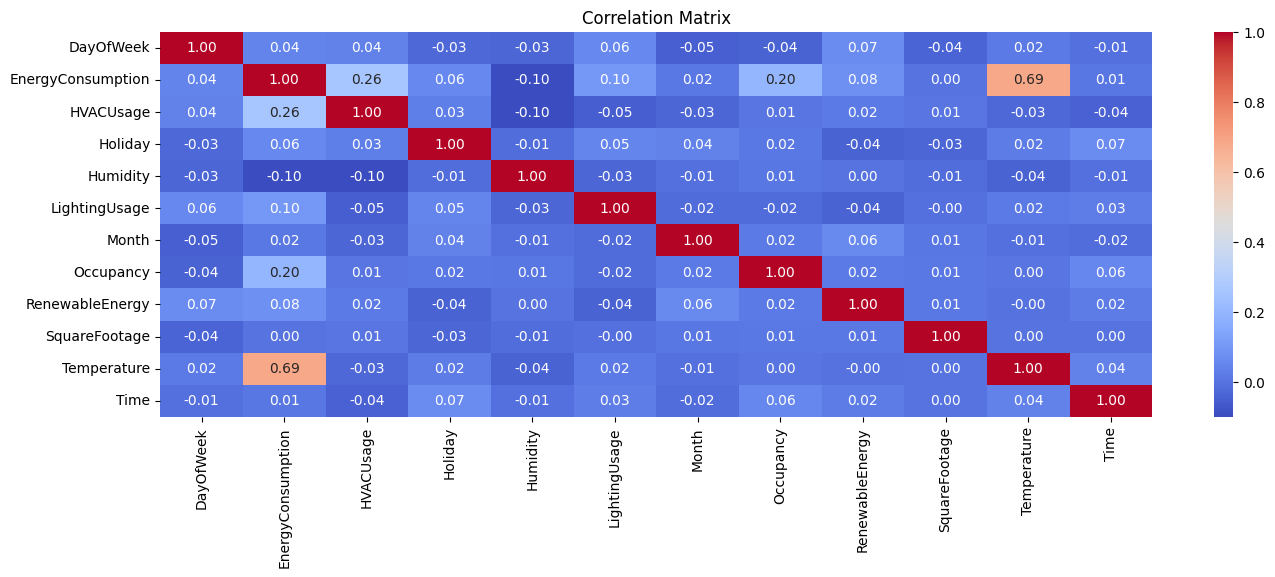

In [34]:
import seaborn as sns
num_cols = df_features.columns.difference(['Date'])

plt.figure(figsize=FIGSIZE)
correlation_matrix = df_features[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')

# Show the plot
plt.title('Correlation Matrix')
plt.show()

## Lagged Correlation (Cross-Correlation)
-  The cross correlation between the target variable (Energy consumption) and input features to find features where their past values influence current value of the target

Observation:
- No strong cross correlation between laged features and the output was found 

The cross correlation between Temperature and Energy consumption


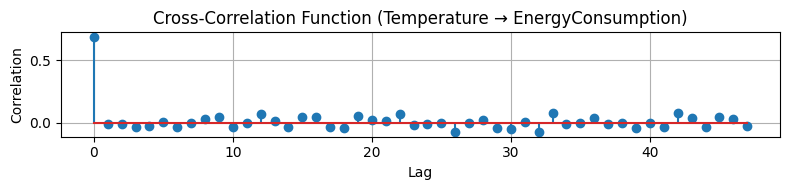

The cross correlation between Humidity and Energy consumption


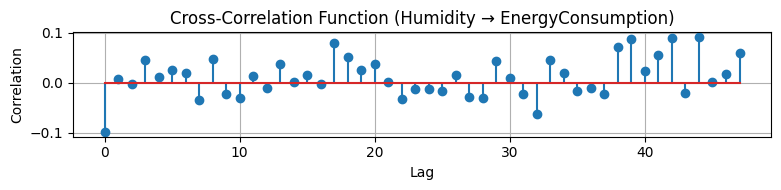

The cross correlation between SquareFootage and Energy consumption


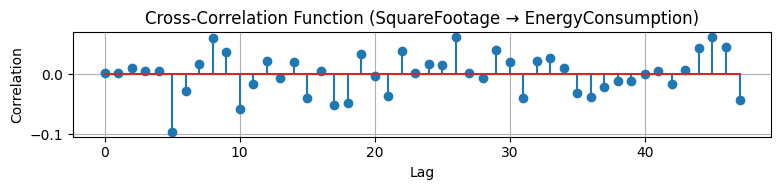

The cross correlation between Occupancy and Energy consumption


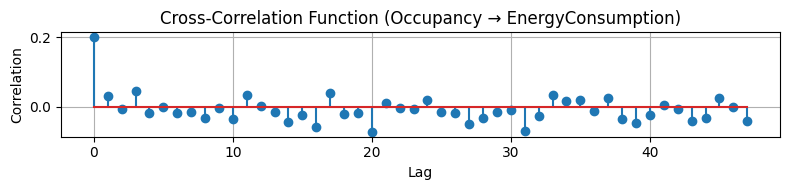

The cross correlation between HVACUsage and Energy consumption


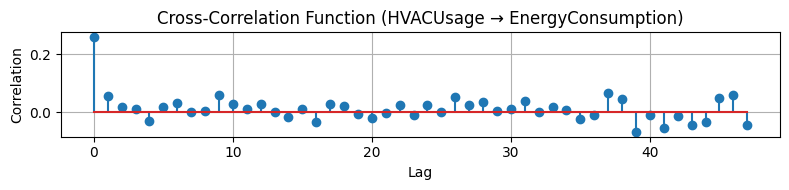

The cross correlation between LightingUsage and Energy consumption


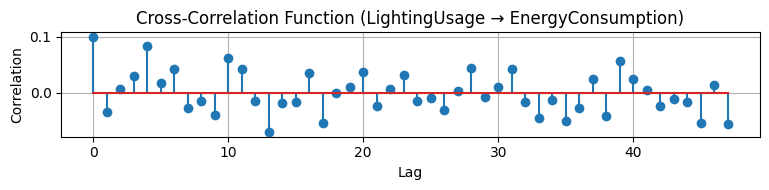

The cross correlation between RenewableEnergy and Energy consumption


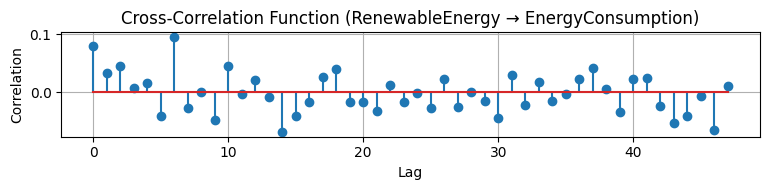

The cross correlation between Holiday and Energy consumption


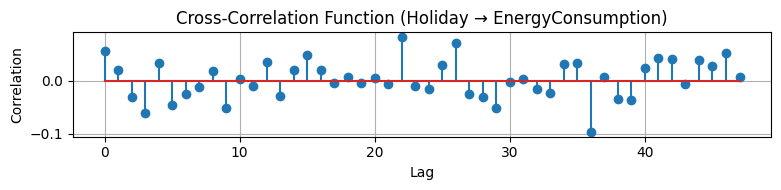

The cross correlation between Time and Energy consumption


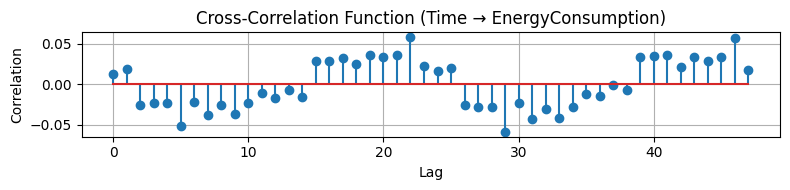

The cross correlation between DayOfWeek and Energy consumption


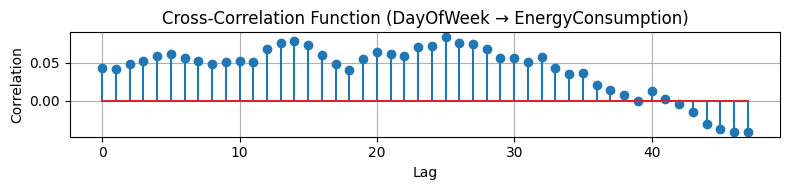

The cross correlation between Month and Energy consumption


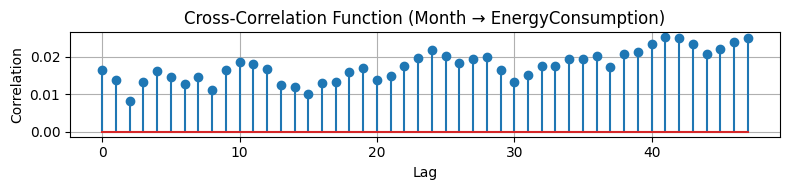

In [16]:
from statsmodels.tsa.stattools import ccf

max_lag = 48
def cross_correlation(df_data, feature_col, max_lag):
    print(f'The cross correlation between {col} and Energy consumption')
    
    # Drop NA and align
    x = df_data[feature_col].dropna()
    y = df_data['EnergyConsumption'].dropna()
    min_len = min(len(x), len(y))
    x = x[-min_len:]
    y = y[-min_len:]

    # Compute cross-correlation
    ccf_vals = ccf(x, y, adjusted=False)
    ccf_vals = ccf_vals[:max_lag]

    # Plot only positive lags
    plt.figure(figsize=(8,2))
    plt.stem(range(len(ccf_vals)), ccf_vals)
    plt.title(f"Cross-Correlation Function ({col} → EnergyConsumption)")
    plt.xlabel("Lag")
    plt.ylabel("Correlation")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# a for loop
lag_features = ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 
                'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'Holiday',
                'Time', 'DayOfWeek', 
                'Month']
for col in lag_features:
    cross_correlation(df_features, col, max_lag)


# SARIMAX (SARIMA with exogenous variable)
- order = (p, d, q) → Non-seasonal ARIMA components
- seasonal_order = (P, D, Q, s) → Seasonal ARIMA

In [273]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import matplotlib.pyplot as plt
from itertools import product

def sarimax_model(train, test,
                  order, seasonal_order,
                  exog_train=None, exog_test=None):
    """
    Fit SARIMAX(train, exog=exog_train, order=order, seasonal_order=seasonal_order),
    forecast `len(test)` steps (with exog=exog_test), and return predictions df.
    """
    model = SARIMAX(train,
                    exog=exog_train,
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",
            message=".*divide by zero encountered.*|.*overflow encountered.*|.*invalid value encountered.*|.*Using zeros.*|.*Maximum Likelihood optimization*.|.*Too few observations*.")
        res = model.fit(disp=False)

    # Forecast 
    forecast = res.forecast(steps=len(test),
                            exog=exog_test)

    df_pred = pd.DataFrame(index=test.index)
    df_pred['prediction'] = forecast.values
    df_pred['truth']      = test.values
    return df_pred, res


def grid_search_sarimax(train, test,
                        p_range=range(0,3),   
                        d_range=range(0,2),
                        q_range=range(0,3),
                        P_range=range(0,2),
                        D_range=range(0,2),
                        Q_range=range(0,2),
                        s=24,                 # seasonal period
                        exog_train=None,
                        exog_test=None, figsize=FIGSIZE_LONG, metric = 'mape', verbose=False):
    """
    Grid‐search SARIMAX over (p,d,q)x(P,D,Q,s) by evaluating `metric` on the hold‐out test.
    Returns: best_params, best_error, all_results
    """
    all_results = []
    total_combos = len(p_range) * len(d_range) * len(q_range) * len(P_range) * len(D_range) * len(Q_range)
    # total_combs = len(product(p_range, d_range, q_range, P_range, D_range, Q_range))
    best_score = np.inf
    for order in product(p_range, d_range, q_range):
        for seasonal in product(P_range, D_range, Q_range):
            seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
            if verbose:
                print(f"Trying SARIMAX(order={order}, seasonal={seasonal_order})")            
            try:
                df_pred, _ = sarimax_model(train, test,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    exog_train=exog_train,
                                    exog_test=exog_test)
                errs = evaluate_model(df_pred, verbose=False)
                score = errs[metric]
            except:
                # print(f"Error fitting SARIMAX")
                score = np.inf
            if score < best_score:
                best_score = score
                print(f"\nSARIMAX(order={order}, seasonal={seasonal_order}, {metric}:{score})") 
            all_results.append((order, seasonal_order, score))
            print(f', {len(all_results)} / {total_combos}', end='')

    # return all_results
    # unpack for plotting
    # orders, errors = zip(*all_results)

    # convert orders to a string for x‐axis labels
    labels = [f"{o}/{s}" for o, s, _ in all_results]
    scores = [sc for _, _, sc in all_results]
    
    best_order, best_mape = extract_best_params(all_results, labels, scores, figsize, metric)

    print(f"Best model coefficients: {best_order} → {metric} = {best_mape:.2f}")
    return best_order, best_mape, all_results


## Exogenous features
We add the additional features such as Temperature, Humidity, Occupancy, Time, and Day Of Week to the model as Exogenous features.

In [175]:
forecast_horizon = 24
ex_cols = df_features.columns.difference(['Date', 'EnergyConsumption'])

exog_train = df_features.iloc[:-forecast_horizon][ex_cols].asfreq('h')
exog_test = df_features.iloc[-forecast_horizon:][ex_cols].asfreq('h')


SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 0, 24), mae:4.376321262823031)
, 1 / 36
SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 1, 24), mae:4.367790960470974)
, 2 / 36
SARIMAX(order=(0, 0, 0), seasonal=(1, 0, 0, 24), mae:4.365472534639044)
, 3 / 36, 4 / 36, 5 / 36, 6 / 36, 7 / 36, 8 / 36
SARIMAX(order=(0, 0, 2), seasonal=(0, 0, 0, 24), mae:4.357826096496894)
, 9 / 36
SARIMAX(order=(0, 0, 2), seasonal=(0, 0, 1, 24), mae:4.340369951924431)
, 10 / 36, 11 / 36, 12 / 36, 13 / 36, 14 / 36, 15 / 36, 16 / 36, 17 / 36, 18 / 36, 19 / 36, 20 / 36, 21 / 36, 22 / 36
SARIMAX(order=(1, 0, 2), seasonal=(1, 0, 0, 24), mae:4.338509645146527)
, 23 / 36, 24 / 36, 25 / 36, 26 / 36, 27 / 36, 28 / 36, 29 / 36
SARIMAX(order=(2, 0, 1), seasonal=(0, 0, 1, 24), mae:4.330855906109271)
, 30 / 36, 31 / 36, 32 / 36, 33 / 36, 34 / 36, 35 / 36, 36 / 36

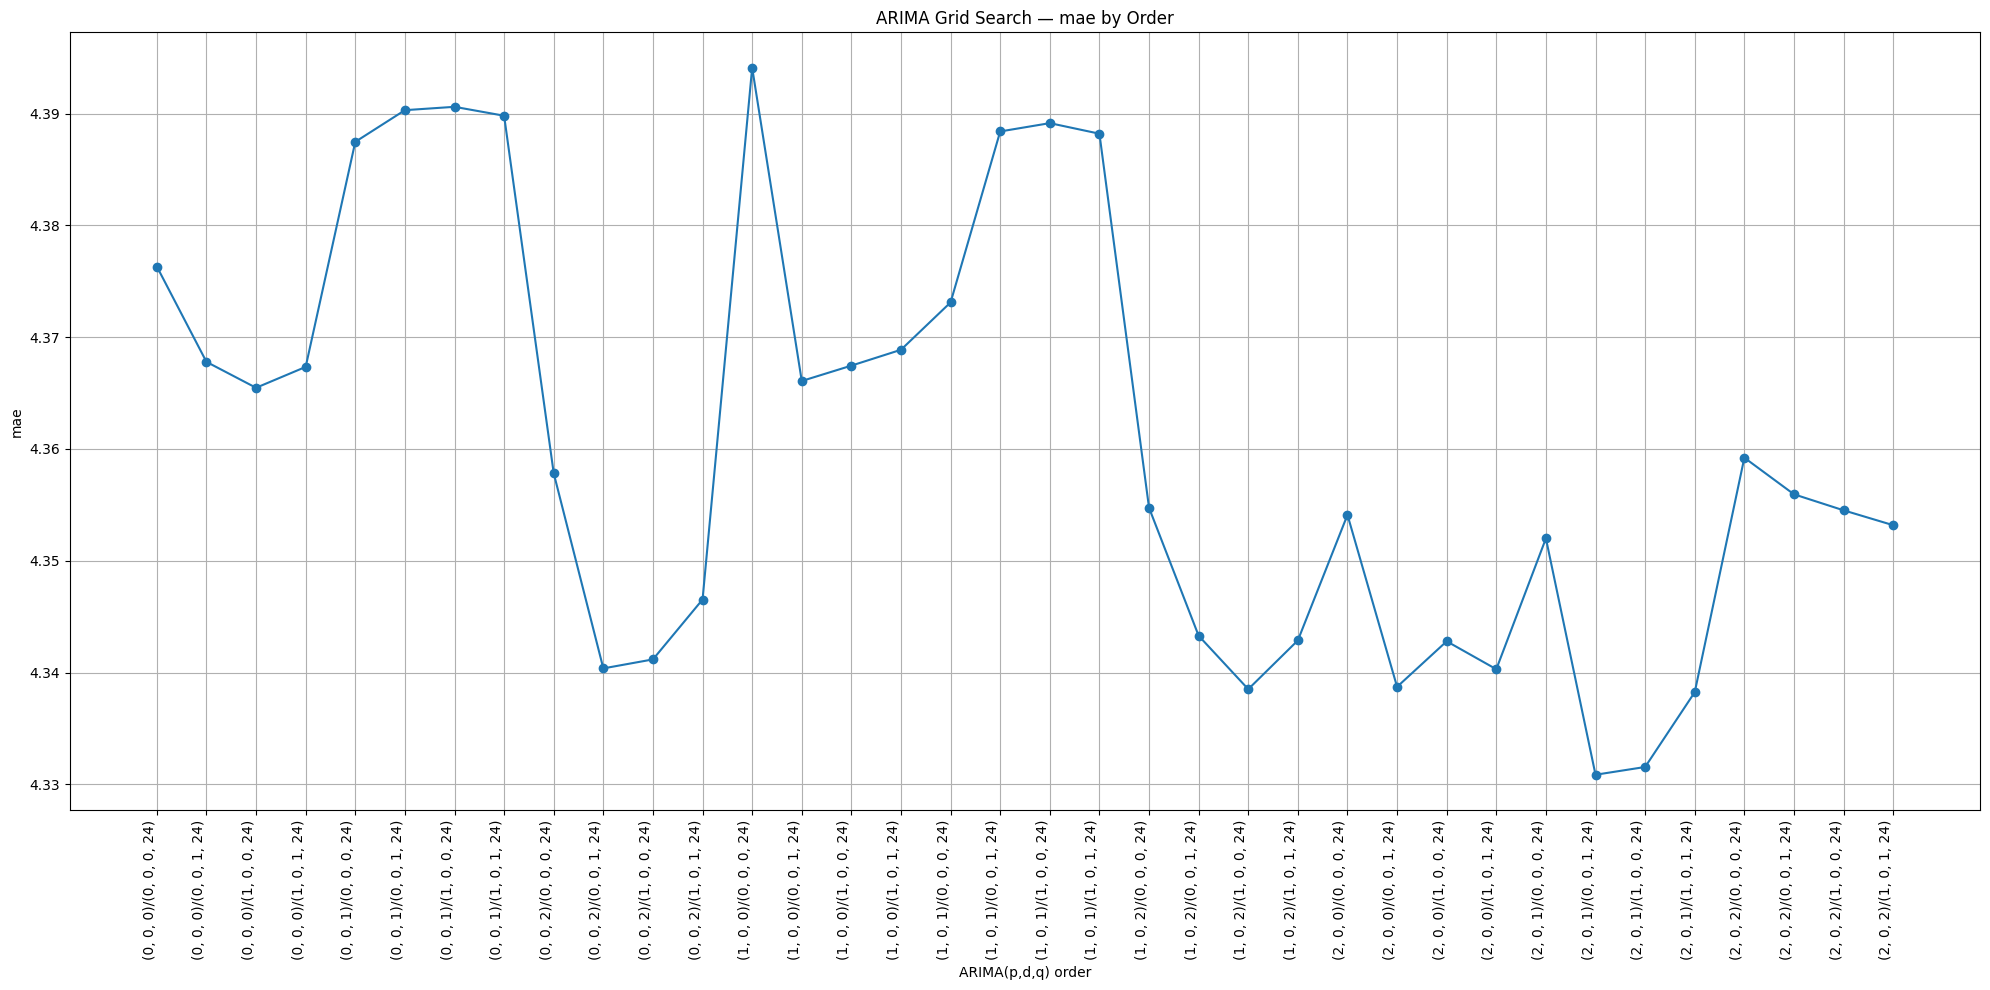

Best ARIMA order: [(2, 0, 1), (0, 0, 1, 24)] → mae = 4.33


In [182]:
(best_order, best_seasonal), best_err, grid_results = grid_search_sarimax(
    train_hr, test_hr,
    p_range=range(3), d_range=[0], q_range=range(3),
    P_range=range(2), D_range=[0], Q_range=range(2),
    s=24,
    exog_train = exog_train,
    exog_test = exog_test,
    metric='mae',
    figsize = (20, 10),
    verbose=False
)

Rolling-Window Forecast Evaluation:
MAE:  4.331
RMSE: 31.853
MAPE: 5.71%
R2:   0.5261


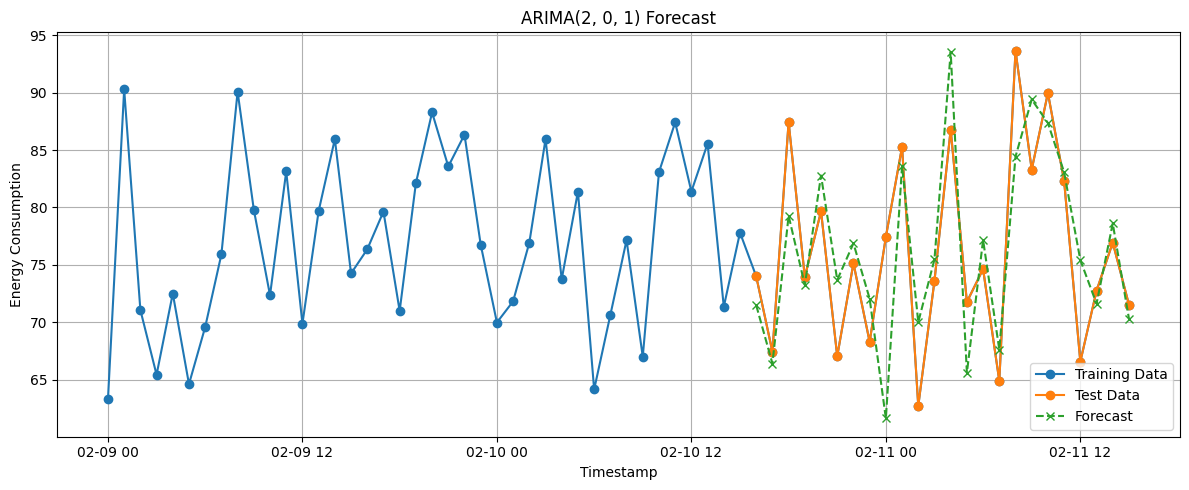

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily,SARIMAX_24h,SARIMAX_24h_FS
mae,6.704103,29.422096,6.745177,20.979117,4.330856,4.037239
rmse,68.050988,1391.544903,66.351638,719.619933,31.852587,29.858486
mape,8.750275,1.557443,9.008152,1.122592,5.705519,5.247213
r2,-0.012465,-0.134533,0.012818,0.413290,0.526096,0.555764


In [184]:
order = best_order
seasonal_order = best_seasonal
# order = (1,0,1)
# seasonal_order = (1,0,1,24)
df_predictions, results = sarimax_model(train_hr, test_hr,
                    order, seasonal_order,
                    exog_train, exog_test)

result_sarimax =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title=f"ARIMA{best_order} Forecast", last_n_samples=64)
df_model_results['SARIMAX_24h'] = result_sarimax
df_model_results

# Feature relevance
We obtain the importance of each input feature to the forcast output based on the coefficients of the fit SARIMAX model.

## training SARIMA on normalized features
This is required to have the coeffcients also normalized and on the same scale to compare regarding their importance

In [191]:
from sklearn.preprocessing import StandardScaler

# Scale your exogenous variables
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train),
    columns=exog_train.columns,
    index=exog_train.index
)
exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test),
    columns=exog_test.columns,
    index=exog_test.index
)

# Then fit SARIMAX with scaled features
model = SARIMAX(train_hr, exog=exog_train_scaled, order=best_order, seasonal_order=best_seasonal)
results = model.fit()


/opt/anaconda3/envs/wwenv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/wwenv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/wwenv/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/opt/anaconda3/envs/wwenv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/wwenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Ploting the feature relevance values
The plot shows the features 'Temperature', 'HVACUsage', 'Occupancy', 'LightingUsage', and Renewable energy have the most relevance in the forecast result.


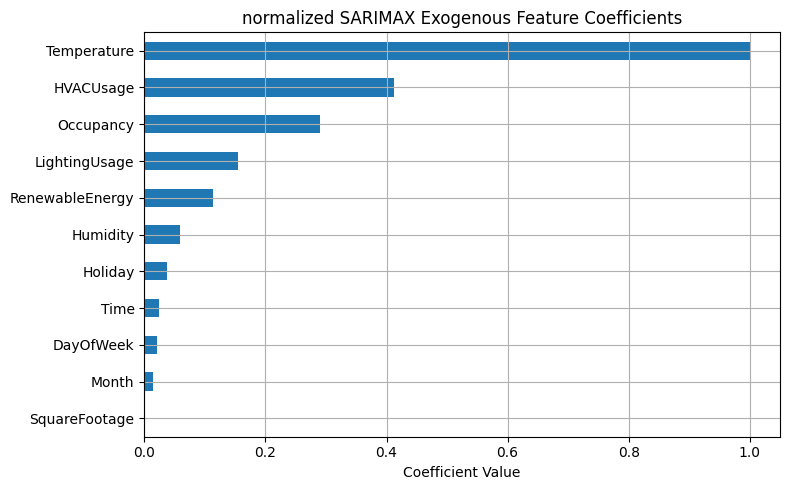

In [198]:
import pandas as pd
import matplotlib.pyplot as plt

# Get all model coefficients as a Series
params = results.params
# print(params)

# Filter out the exogenous coefficients only
# These typically start with the feature names as provided in X_train.columns
exog_cols = exog_train.columns
exog_params = params[params.index.isin(exog_cols)].abs()

# Sort by absolute value for relevance
exog_params_sorted = exog_params.reindex(
    exog_params.sort_values(ascending=False).index
)
exog_params_sorted = exog_params_sorted/exog_params_sorted.max()

# Plot
plt.figure(figsize=(8, 5))
exog_params_sorted.plot(kind='barh')
plt.title("normalized SARIMAX Exogenous Feature Coefficients")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()  # most important at top
plt.grid(True)
plt.tight_layout()
plt.show()


## Commulative relevance
We investigate the added relevance of combined features based on the ranked feature importance list

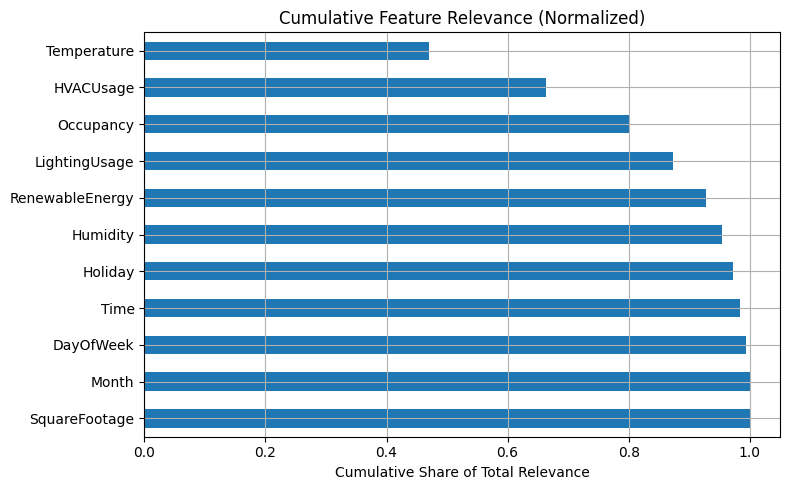

In [199]:
# Compute total sum
total_relevance = exog_params_sorted.sum()

# Compute cumulative relevance from least to most important
cumulative = exog_params_sorted.cumsum() / total_relevance

# Plot
plt.figure(figsize=(8, 5))
cumulative.plot(kind='barh')
plt.title("Cumulative Feature Relevance (Normalized)")
plt.xlabel("Cumulative Share of Total Relevance")
plt.gca().invert_yaxis()  # most important at top
plt.grid(True)
plt.tight_layout()
plt.show()


## Grid search on top relevant exogenous features
We extend the grid search based on the selected subset of features to find the best SARIMAX model parameters for them

Index(['Temperature', 'HVACUsage', 'Occupancy', 'LightingUsage'], dtype='object')

SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 0, 24), mae:4.563965474353285)
, 1 / 900
SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 1, 24), mae:4.553729760557013)
, 2 / 900
SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 2, 24), mae:4.532617239329761)
, 3 / 900, 4 / 900, 5 / 900, 6 / 900, 7 / 900, 8 / 900, 9 / 900, 10 / 900, 11 / 900, 12 / 900, 13 / 900, 14 / 900, 15 / 900, 16 / 900, 17 / 900, 18 / 900, 19 / 900, 20 / 900
SARIMAX(order=(0, 0, 2), seasonal=(0, 0, 2, 24), mae:4.517242727321389)
, 21 / 900, 22 / 900, 23 / 900, 24 / 900, 25 / 900, 26 / 900, 27 / 900, 28 / 900, 29 / 900, 30 / 900, 31 / 900, 32 / 900, 33 / 900, 34 / 900, 35 / 900, 36 / 900, 37 / 900, 38 / 900, 39 / 900, 40 / 900, 41 / 900, 42 / 900, 43 / 900, 44 / 900, 45 / 900, 46 / 900, 47 / 900, 48 / 900, 49 / 900, 50 / 900, 51 / 900, 52 / 900, 53 / 900, 54 / 900, 55 / 900, 56 / 900, 57 / 900, 58 / 900, 59 / 900, 60 / 900, 61 / 900, 62 / 900, 63 / 900, 64 

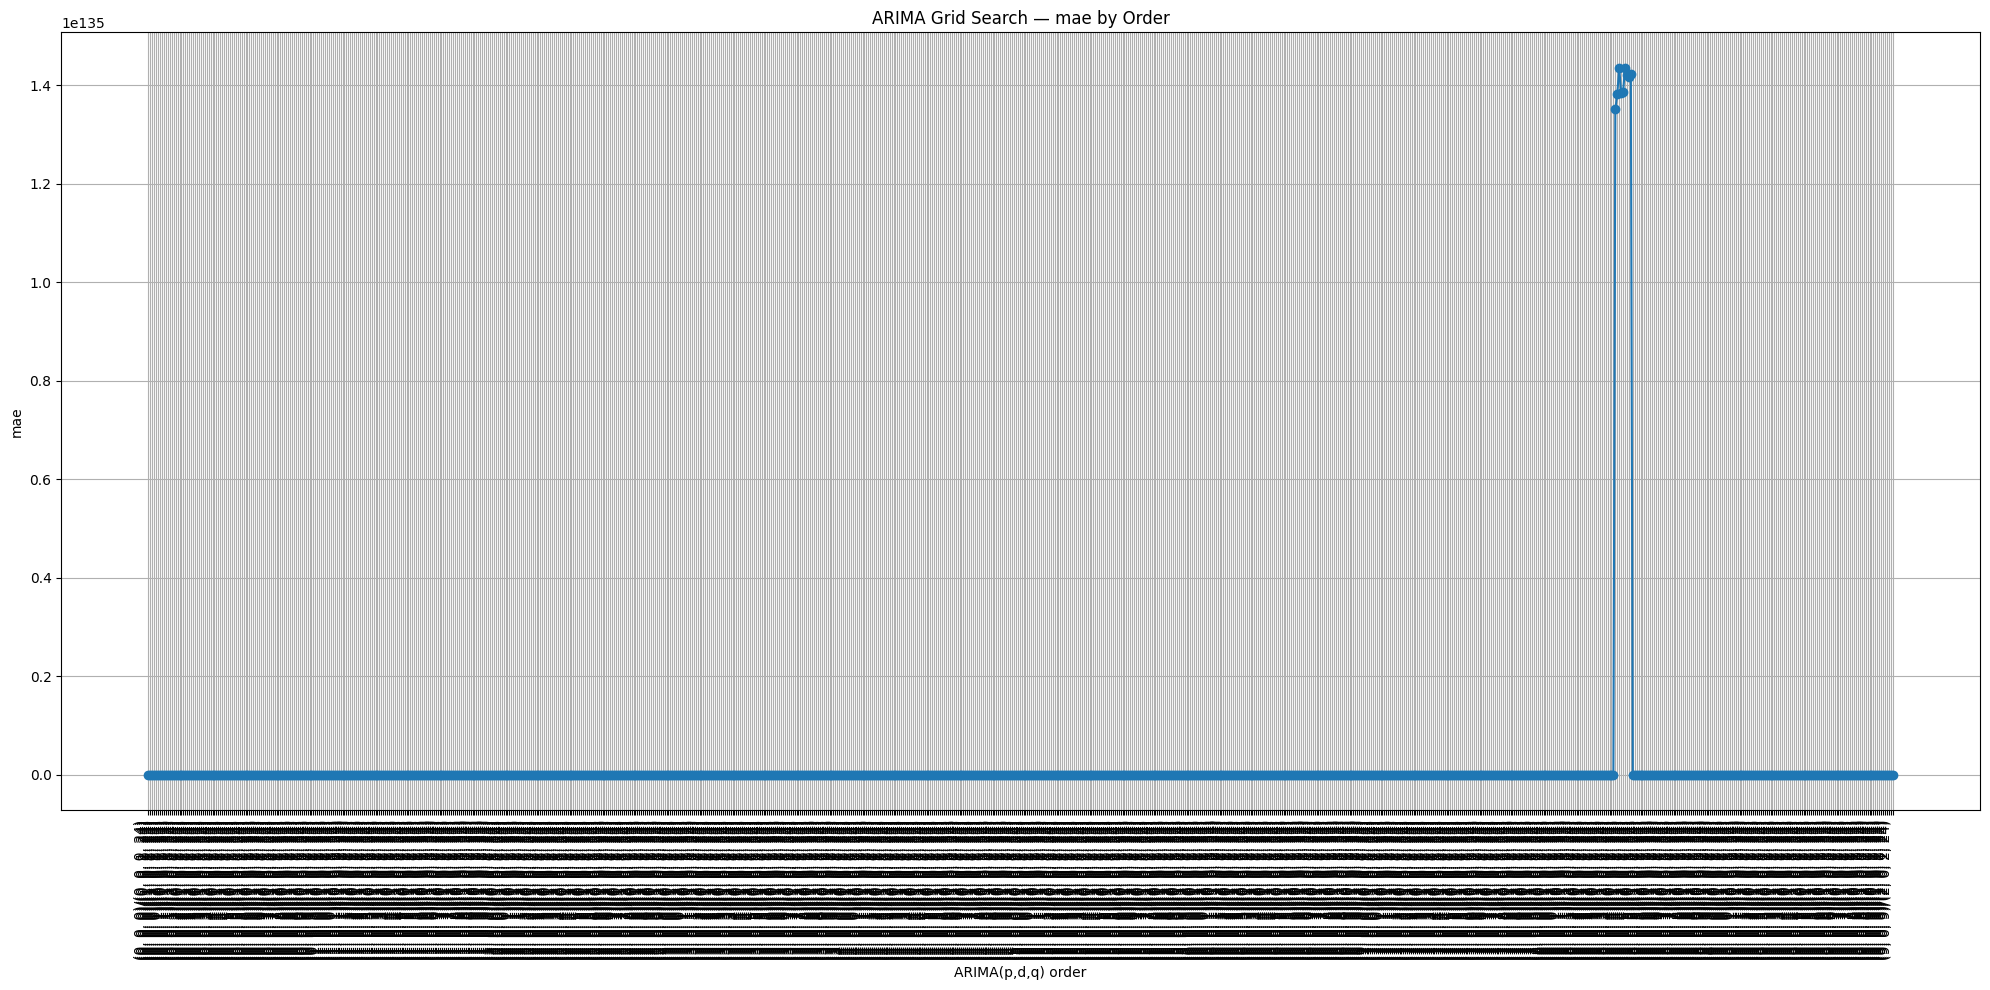

Best model coefficients: [(6, 0, 7), (2, 0, 1, 24)] → mae = 4.41
Rolling-Window Forecast Evaluation:
MAE:  4.412
RMSE: 39.231
MAPE: 5.69%
R2:   0.4163


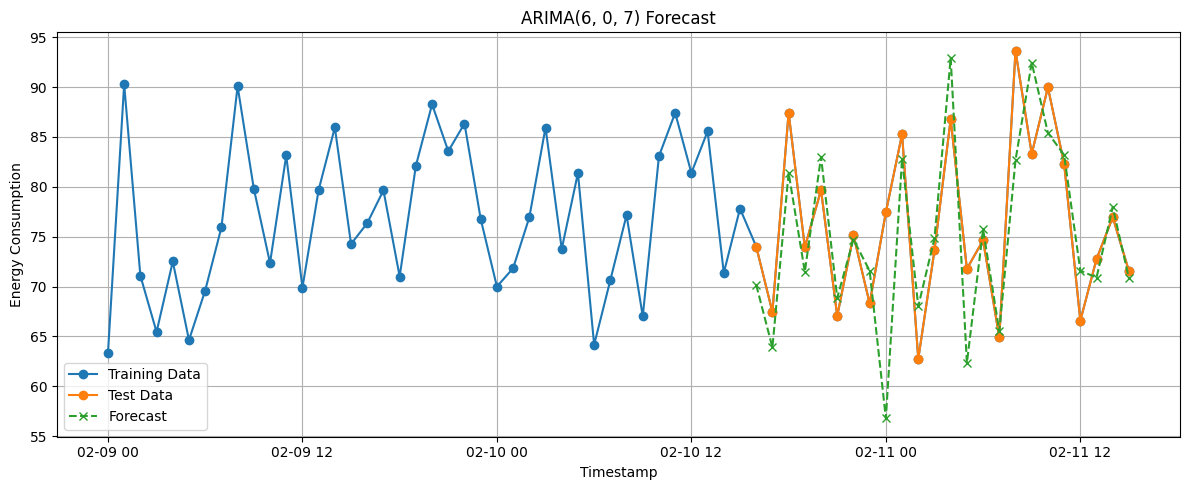

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily,SARIMAX_24h,SARIMAX_24h_FS
mae,6.704103,29.422096,6.745177,20.979117,4.330856,4.411859
rmse,68.050988,1391.544903,66.351638,719.619933,31.852587,39.230936
mape,8.750275,1.557443,9.008152,1.122592,5.705519,5.689949
r2,-0.012465,-0.134533,0.012818,0.413290,0.526096,0.416320


In [203]:
features_selected = cumulative[cumulative < .9].index
print(features_selected)
df_features_selected = df_features[features_selected]

exog_train_sel = df_features.iloc[:-forecast_horizon][features_selected].asfreq('h')
exog_test_sel = df_features.iloc[-forecast_horizon:][features_selected].asfreq('h')


(best_order, best_seasonal), best_err, grid_results = grid_search_sarimax(
    train_hr, test_hr,
    p_range=range(10), d_range=[0], q_range=range(10),
    P_range=range(3), D_range=[0], Q_range=range(3),
    s=24,
    exog_train = exog_train_sel,
    exog_test = exog_test_sel,
    metric='mae',
    figsize = (20, 10),
    verbose=False
)

order = best_order
seasonal_order = best_seasonal
# order = (6, 0, 7)
# seasonal_order =  (2, 0, 1, 24)
df_predictions, results = sarimax_model(train_hr, test_hr,
                    order, seasonal_order,
                    exog_train_sel, exog_test_sel)

result_sarimax =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_data, title=f"ARIMA{best_order} Forecast", last_n_samples=64)
df_model_results['SARIMAX_24h_FS'] = result_sarimax
df_model_results

# Apply SARIMAX on daily consumption data
- Although number of training samples in the daily data is less than the desired training size for fitting the SARIMAX model, we still fit the model to the daily data to see it's forecast performance for a 7-day horizon.

Results:
- The SARIMAX model fitted to the daily data with exogenous features has a also a better performance than the the ARIMA model and the baseline for the 7-day forecast.
- However, in a real scenario, evaluation of the model using a cross validation will not be possible due to the limited number of training samples. Hence, this result is not reliable for production purpose.


SARIMAX(order=(0, 0, 0), seasonal=(0, 0, 0, 7), mae:16.208638835260086)
, 1 / 1296, 2 / 1296, 3 / 1296
SARIMAX(order=(0, 0, 0), seasonal=(1, 0, 0, 7), mae:16.17756545363974)
, 4 / 1296, 5 / 1296, 6 / 1296, 7 / 1296, 8 / 1296, 9 / 1296, 10 / 1296, 11 / 1296, 12 / 1296, 13 / 1296, 14 / 1296, 15 / 1296, 16 / 1296, 17 / 1296, 18 / 1296
SARIMAX(order=(0, 0, 2), seasonal=(0, 0, 0, 7), mae:9.787359188377943)
, 19 / 1296, 20 / 1296, 21 / 1296, 22 / 1296, 23 / 1296, 24 / 1296, 25 / 1296, 26 / 1296, 27 / 1296, 28 / 1296, 29 / 1296, 30 / 1296, 31 / 1296, 32 / 1296, 33 / 1296, 34 / 1296, 35 / 1296, 36 / 1296, 37 / 1296, 38 / 1296, 39 / 1296, 40 / 1296, 41 / 1296, 42 / 1296, 43 / 1296, 44 / 1296, 45 / 1296, 46 / 1296, 47 / 1296, 48 / 1296, 49 / 1296, 50 / 1296, 51 / 1296, 52 / 1296, 53 / 1296, 54 / 1296, 55 / 1296, 56 / 1296, 57 / 1296, 58 / 1296, 59 / 1296, 60 / 1296, 61 / 1296, 62 / 1296, 63 / 1296, 64 / 1296, 65 / 1296, 66 / 1296, 67 / 1296, 68 / 1296, 69 / 1296, 70 / 1296, 71 / 1296, 72 / 1296

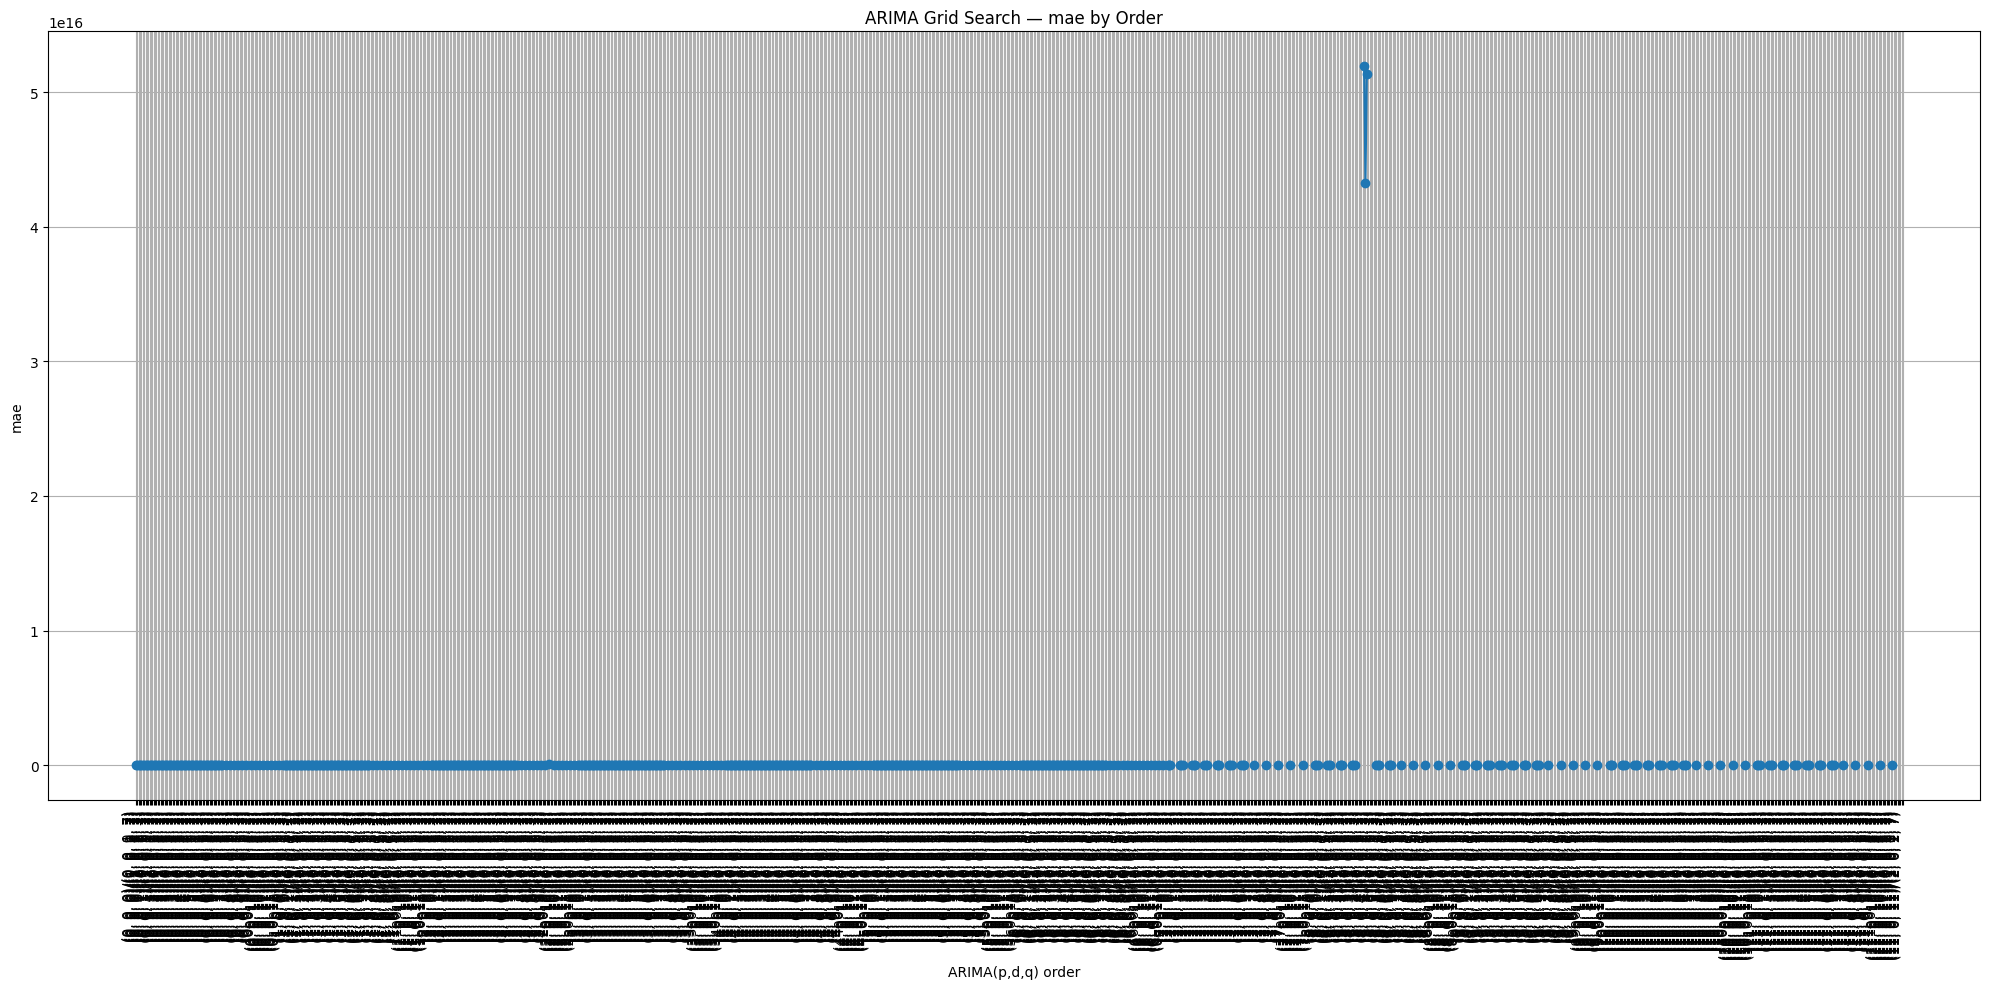

Best model coefficients: [(5, 0, 3), (1, 0, 0, 7)] → mae = 7.70
Rolling-Window Forecast Evaluation:
MAE:  7.699
RMSE: 161.900
MAPE: 0.41%
R2:   0.8680


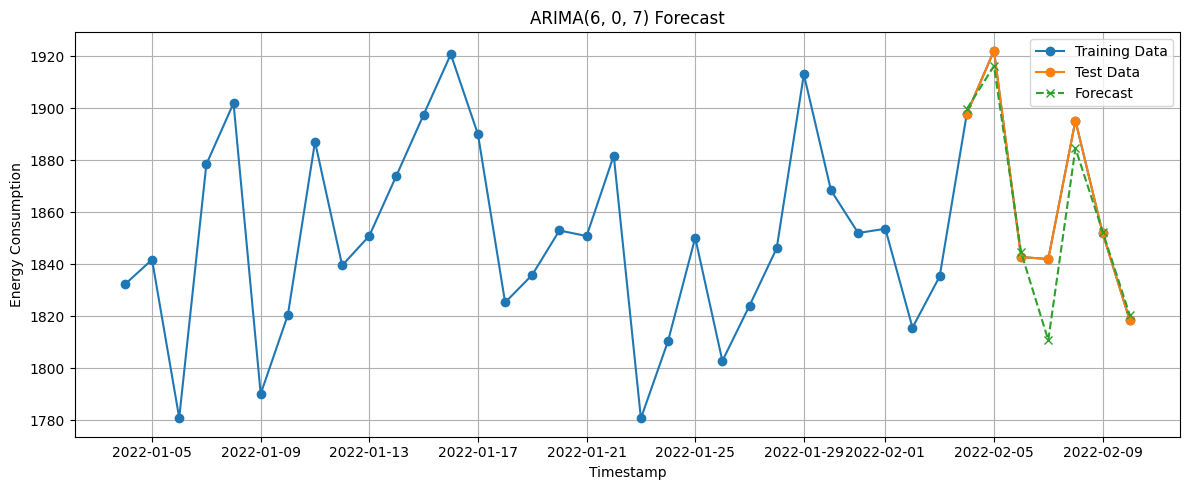

,Baseline_24h,Baseline_Daily,ARIMA_24h,ARIMA_Daily,SARIMAX_24h,SARIMAX_24h_FS,SARIMAX_Daily
mae,6.704103,29.422096,6.745177,20.979117,4.330856,4.411859,7.698735
rmse,68.050988,1391.544903,66.351638,719.619933,31.852587,39.230936,161.900488
mape,8.750275,1.557443,9.008152,1.122592,5.705519,5.689949,0.413495
r2,-0.012465,-0.134533,0.012818,0.413290,0.526096,0.416320,0.868002


In [286]:
forecast_horizon = 7

agg_dict = {
    'EnergyConsumption': 'sum',  # sum over day
    'Temperature': 'mean',
    'Humidity': 'mean',
    'SquareFootage': 'mean',
    'Occupancy': 'mean',    
    'RenewableEnergy': 'mean',
    'LightingUsage':'sum',
    'HVACUsage':'sum',
    'Holiday':'sum',
    'Month':'mean'
}
df_daily = df_features[df_features.index<'2022-02-11'].resample('D').agg(agg_dict)

# df_daily = df_features['EnergyConsumption'].resample('D').sum()
# df_daily = df_features.to_frame()
ex_cols_daily = ex_cols.difference(['Time', 'DayOfWeek'])

train_day = df_daily.iloc[:-forecast_horizon][target_col].asfreq('D')
test_day = df_daily.iloc[-forecast_horizon:][target_col].asfreq('D')

exog_train_day = df_daily.iloc[:-forecast_horizon][ex_cols_daily].asfreq('D')
exog_test_day = df_daily.iloc[-forecast_horizon:][ex_cols_daily].asfreq('D')

# grid search
(best_order_d, best_seasonal_d), best_err_d, grid_results_d = grid_search_sarimax(
    train_day, test_day,
    p_range=range(12), d_range=[0], q_range=range(12),
    P_range=range(3), D_range=[0], Q_range=range(3),
    s=7,
    exog_train = exog_train_day,
    exog_test = exog_test_day,
    metric='mae',
    figsize = (20, 10),
    verbose=False
)

# Best model coefficients: [(5, 0, 3), (1, 0, 0, 7)] → mae = 7.70
# order = (5, 0, 3)
# seasonal_order =  (1, 0, 0, 7)
order = best_order_d
seasonal_order =  best_seasonal_d
df_predictions, model = sarimax_model(train_day, test_day,
                    order, seasonal_order,
                    exog_train_day, exog_test_day)

result_sarimax =  evaluate_model(df_predictions, verbose=True)
visualize_prediction(df_predictions, df_daily, title=f"ARIMA{best_order} Forecast", last_n_samples=64)
df_model_results['SARIMAX_Daily'] = result_sarimax
df_model_results

## Feature Relevance for daily data
- Calculating the feature relevance for the daily data is similar to the hourly data, especially for the most important feature, Temperature.
- However, the Humidity and Holiday also influence the daily forecast result.


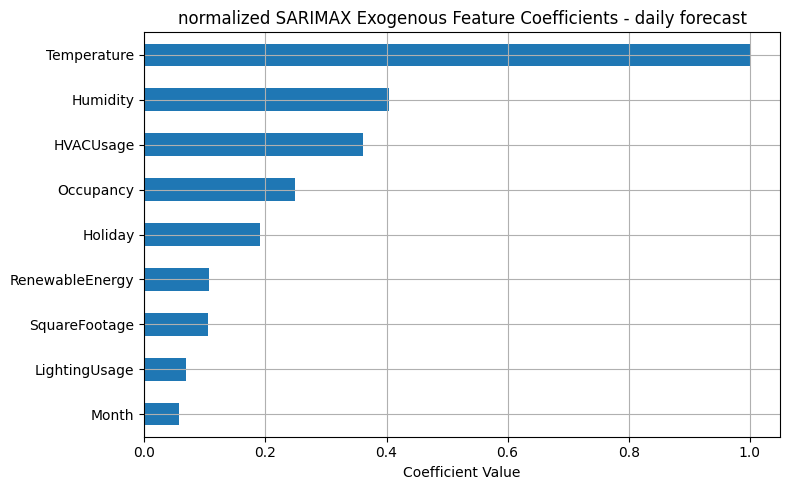

Top 90% of relevant features:  ['Temperature', 'Humidity', 'HVACUsage', 'Occupancy', 'Holiday']


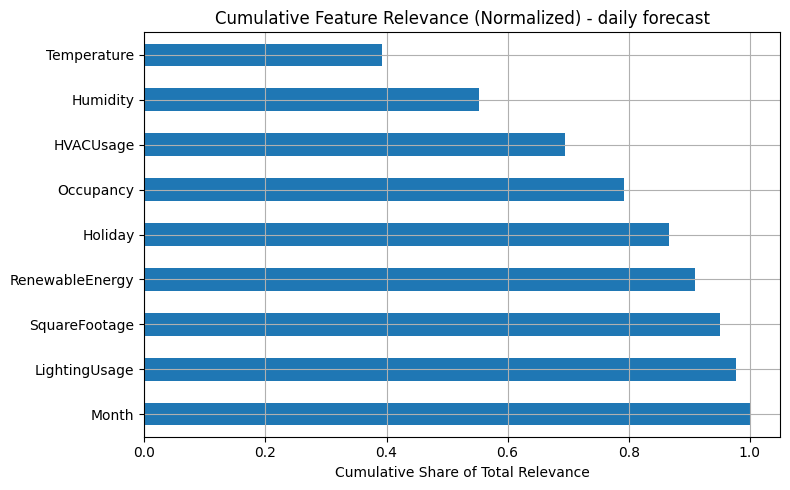

In [303]:
# Scale your exogenous variables
scaler = StandardScaler()
exog_train_scaled = pd.DataFrame(
    scaler.fit_transform(exog_train_day),
    columns=exog_train_day.columns,
    index=exog_train_day.index
)
exog_test_scaled = pd.DataFrame(
    scaler.transform(exog_test_day),
    columns=exog_test_day.columns,
    index=exog_test_day.index
)

# Then fit SARIMAX with scaled features
with warnings.catch_warnings():
    # ignore all warnings
    warnings.filterwarnings("ignore")
    model = SARIMAX(train_day, exog=exog_train_scaled, order=best_order_d, seasonal_order=best_seasonal_d)
    results = model.fit()

# Get all model coefficients as a Series
params = results.params

# Filter out the exogenous coefficients only
exog_cols = exog_train_day.columns
exog_params = params[params.index.isin(exog_cols)].abs()

# Sort by absolute value for relevance
exog_params_sorted = exog_params.reindex(
    exog_params.sort_values(ascending=False).index
)
exog_params_sorted = exog_params_sorted/exog_params_sorted.max()

# Plot
plt.figure(figsize=(8, 5))
exog_params_sorted.plot(kind='barh')
plt.title("normalized SARIMAX Exogenous Feature Coefficients - daily forecast")
plt.xlabel("Coefficient Value")
plt.gca().invert_yaxis()  # most important at top
plt.grid(True)
plt.tight_layout()
plt.show()

# cumulative
total_relevance = exog_params_sorted.sum()
cumulative = exog_params_sorted.cumsum() / total_relevance

features_selected_day = cumulative[cumulative < .9].index
print('Top 90% of relevant features: ', list(features_selected_day))

# Plot
plt.figure(figsize=(8, 5))
cumulative.plot(kind='barh')
plt.title("Cumulative Feature Relevance (Normalized) - daily forecast")
plt.xlabel("Cumulative Share of Total Relevance")
plt.gca().invert_yaxis()  # most important at top
plt.grid(True)
plt.tight_layout()
plt.show()